In [1]:
import os

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP          = os.path.sep
SPLITED_PATH = os.getcwd().split(SEP)
TIDX         = SPLITED_PATH.index('TIL')

ROOT_PATH    = SEP.join(SPLITED_PATH[ :TIDX + 1])
DATA_PATH    = f'{ROOT_PATH}/Dataset/smoking'

In [3]:
train_df     = pd.read_csv(f'{DATA_PATH}/train.csv')
valid_df     = pd.read_csv(f'{DATA_PATH}/test.csv')
submission   = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

<Axes: >

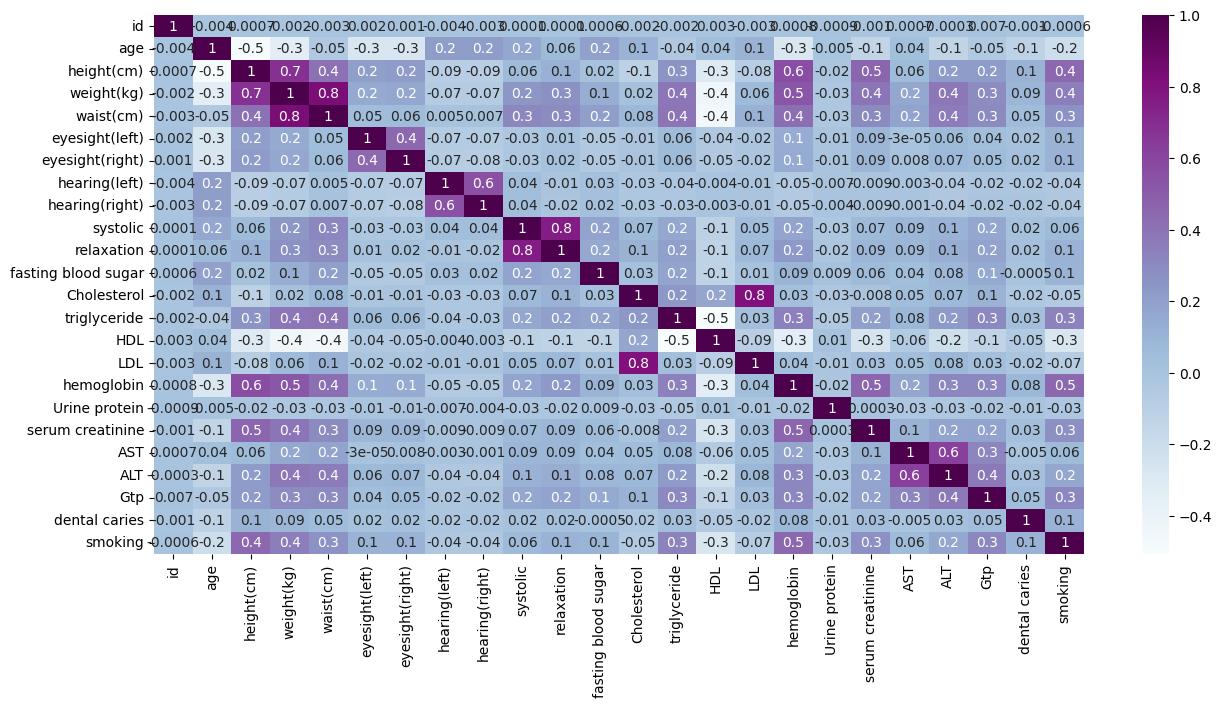

In [4]:
plt.figure(figsize = (15, 7))
sns.heatmap(train_df.corr(), cmap = 'BuPu', annot = True, fmt = '.1g')

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'height(cm)'}>,
        <Axes: title={'center': 'weight(kg)'}>,
        <Axes: title={'center': 'waist(cm)'}>],
       [<Axes: title={'center': 'eyesight(left)'}>,
        <Axes: title={'center': 'eyesight(right)'}>,
        <Axes: title={'center': 'relaxation'}>,
        <Axes: title={'center': 'fasting blood sugar'}>],
       [<Axes: title={'center': 'triglyceride'}>,
        <Axes: title={'center': 'HDL'}>,
        <Axes: title={'center': 'hemoglobin'}>,
        <Axes: title={'center': 'serum creatinine'}>],
       [<Axes: title={'center': 'ALT'}>, <Axes: title={'center': 'Gtp'}>,
        <Axes: title={'center': 'dental caries'}>,
        <Axes: title={'center': 'smoking'}>]], dtype=object)

<Figure size 1500x700 with 0 Axes>

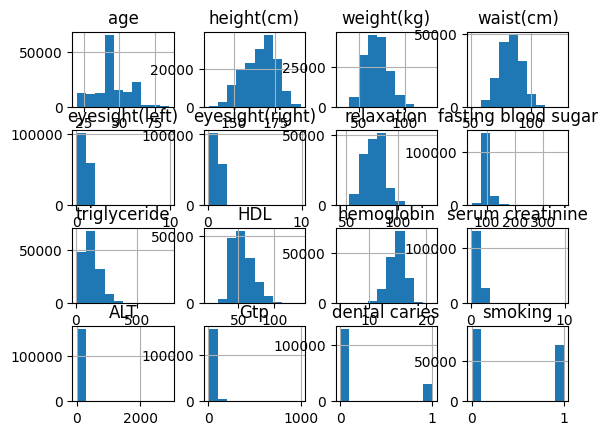

In [5]:
drop_cols = ['id', 'hearing(left)', 'hearing(right)', 'systolic',
             'Cholesterol', 'LDL', 'Urine protein', 'AST']

train_df = train_df.drop(drop_cols, axis = 1)
plt.figure(figsize = (15, 7))
train_df.hist()

In [6]:
x        = train_df.drop('smoking', axis = 1)
y        = train_df.smoking

scaler   = MinMaxScaler()
scaled_x = scaler.fit_transform(x) 

train_x, test_x, train_y, test_y = train_test_split(scaled_x, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 99)

In [7]:
boost = GradientBoostingClassifier(
            loss = 'deviance', criterion = 'squared_error', 
            max_depth = 10, n_estimators = 500
        )

boost.fit(train_x, train_y)

/home/utils/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(criterion='squared_error', loss='deviance',
                           max_depth=10, n_estimators=500)

In [8]:
print(f'train score : {boost.score(train_x, train_y):.3f}')
print(f'test  score : {boost.score( test_x,  test_y):.3f}')

train score : 0.995
test  score : 0.772


In [9]:
train_pred = boost.predict(train_x)
test_pred  = boost.predict(test_x)

print(classification_report(train_pred, train_y))
print(classification_report( test_pred,  test_y))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     71462
           1       1.00      0.99      0.99     55942

    accuracy                           1.00    127404
   macro avg       1.00      1.00      1.00    127404
weighted avg       1.00      1.00      1.00    127404

              precision    recall  f1-score   support

           0       0.76      0.82      0.79     16647
           1       0.79      0.72      0.75     15205

    accuracy                           0.77     31852
   macro avg       0.77      0.77      0.77     31852
weighted avg       0.77      0.77      0.77     31852



In [10]:
xgboost = XGBClassifier(n_estimators = 1_000, learning_rate = 0.15, 
                        max_depth = 5)
xgboost.fit(train_x, train_y, early_stopping_rounds = 500, verbose = False,
            eval_set = [(test_x, test_y)], eval_metric = 'logloss')

/home/utils/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/utils/anaconda3/envs/ml/lib/python3.10/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
train_pred = xgboost.predict(train_x)
test_pred  = xgboost.predict(test_x)

print(f'train score : {xgboost.score(train_x, train_y):.3f}')
print(f' test score : {xgboost.score( test_x,  test_y):.3f}')

print(classification_report(train_pred, train_y))
print(classification_report( test_pred,  test_y))

train score : 0.817
 test score : 0.779
              precision    recall  f1-score   support

           0       0.80      0.87      0.83     65548
           1       0.85      0.76      0.80     61856

    accuracy                           0.82    127404
   macro avg       0.82      0.82      0.82    127404
weighted avg       0.82      0.82      0.82    127404

              precision    recall  f1-score   support

           0       0.76      0.83      0.79     16316
           1       0.80      0.72      0.76     15536

    accuracy                           0.78     31852
   macro avg       0.78      0.78      0.78     31852
weighted avg       0.78      0.78      0.78     31852



In [12]:
lgbm = LGBMClassifier(n_estimators = 4_000)
lgbm.fit(train_x, train_y, eval_metric = 'logloss', eval_set = [(test_x, test_y)])

[LightGBM] [Info] Number of positive: 55722, number of negative: 71682
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437365 -> initscore=-0.251865
[LightGBM] [Info] Start training from score -0.251865


LGBMClassifier(n_estimators=4000)

In [13]:
print(f'train score : {lgbm.score(train_x, train_y):.3f}')
print(f' test score : {lgbm.score( test_x,  test_y):.3f}')

train_pred = lgbm.predict(train_x)
test_pred  = lgbm.predict(test_x)

print(classification_report(train_pred, train_y))
print(classification_report( test_pred,  test_y))

train score : 0.958
 test score : 0.772
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     69155
           1       0.98      0.93      0.95     58249

    accuracy                           0.96    127404
   macro avg       0.96      0.96      0.96    127404
weighted avg       0.96      0.96      0.96    127404

              precision    recall  f1-score   support

           0       0.77      0.82      0.79     16772
           1       0.78      0.72      0.75     15080

    accuracy                           0.77     31852
   macro avg       0.77      0.77      0.77     31852
weighted avg       0.77      0.77      0.77     31852



In [14]:
valid_df              = valid_df.drop(drop_cols, axis = 1)
scaled_x              = scaler.fit_transform(valid_df)
valid_pred            = lgbm.predict(scaled_x)
submission['smoking'] = valid_pred

In [15]:
os.makedirs('submissions/smoking', exist_ok = True)
submission.to_csv('submissions/smoking/smoking_lgbm.csv', index = False)